# Sales

## Notebook set-up

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer, FunctionTransformer, PolynomialFeatures

import helper_functions as funcs

label = 'Sales'

## 1. Asset loading

### 1.1. Data

In [2]:
with open('../data/processed/sales.pkl', 'rb') as input_file:
    sales_data = pickle.load(input_file)

train_df = sales_data['training']
test_df = sales_data['testing']

In [3]:
train_df.head()

,Segment,City,State,Sub_Category,Sales,Order_Year,Order_Month,Order_Day
2434,Corporate,Springfield,Virginia,Envelopes,33.960,2016,11,0
9746,Consumer,Los Angeles,California,Tables,71.088,2018,11,5
2289,Corporate,Seattle,Washington,Tables,892.980,2018,1,0
7070,Home Office,Chicago,Illinois,Paper,9.248,2017,9,1
7989,Home Office,Sheboygan,Wisconsin,Storage,14.970,2017,8,2


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6536 entries, 2434 to 4359
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Segment       6536 non-null   object 
 1   City          6536 non-null   object 
 2   State         6536 non-null   object 
 3   Sub_Category  6536 non-null   object 
 4   Sales         6536 non-null   float64
 5   Order_Year    6536 non-null   int32  
 6   Order_Month   6536 non-null   int32  
 7   Order_Day     6536 non-null   int32  
dtypes: float64(1), int32(3), object(4)
memory usage: 383.0+ KB


## 2. Data preparation

### 2.1. Aggregation

#### 2.1.1. Get monthly sales totals

In [5]:
train_monthly_total_df = train_df.groupby(['Segment', 'State', 'Sub_Category', 'Order_Month', 'Order_Year'])['Sales'].sum().reset_index()
test_monthly_total_df = test_df.groupby(['Segment', 'State', 'Sub_Category', 'Order_Month', 'Order_Year'])['Sales'].sum().reset_index()
train_monthly_total_df.head()

,Segment,State,Sub_Category,Order_Month,Order_Year,Sales
0,Consumer,Alabama,Accessories,11,2018,239.92
1,Consumer,Alabama,Art,11,2015,14.67
2,Consumer,Alabama,Binders,5,2017,22.75
3,Consumer,Alabama,Binders,9,2017,62.94
4,Consumer,Alabama,Binders,12,2015,152.76


#### 2.1.2. Average across years

In [6]:
train_df = train_monthly_total_df.groupby(['Segment', 'State', 'Sub_Category', 'Order_Month'])['Sales'].mean().reset_index()
test_df = test_monthly_total_df.groupby(['Segment', 'State', 'Sub_Category', 'Order_Month'])['Sales'].mean().reset_index()
train_df.head()

,Segment,State,Sub_Category,Order_Month,Sales
0,Consumer,Alabama,Accessories,11,239.92
1,Consumer,Alabama,Art,11,14.67
2,Consumer,Alabama,Binders,5,22.75
3,Consumer,Alabama,Binders,9,62.94
4,Consumer,Alabama,Binders,12,152.76


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Segment       3887 non-null   object 
 1   State         3887 non-null   object 
 2   Sub_Category  3887 non-null   object 
 3   Order_Month   3887 non-null   int32  
 4   Sales         3887 non-null   float64
dtypes: float64(1), int32(1), object(3)
memory usage: 136.8+ KB


### 2.2. One-hot encoding

In [8]:
features = ['Segment', 'State', 'Sub_Category']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')

encoded_training_features = onehot_encoder.fit_transform(train_df[features])
encoded_testing_features = onehot_encoder.transform(test_df[features])

encoded_training_df = pd.DataFrame(
    encoded_training_features,
    columns=onehot_encoder.get_feature_names_out()
)

encoded_testing_df = pd.DataFrame(
    encoded_testing_features,
    columns=onehot_encoder.get_feature_names_out()
)

train_df.drop(columns=features, inplace=True)
test_df.drop(columns=features, inplace=True)

train_df = pd.concat([encoded_training_df.reset_index(drop=True), train_df.reset_index(drop=True)], axis=1)
test_df = pd.concat([encoded_testing_df.reset_index(drop=True), test_df.reset_index(drop=True)], axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Segment_Consumer            3887 non-null   float64
 1   Segment_Corporate           3887 non-null   float64
 2   Segment_Home Office         3887 non-null   float64
 3   State_Alabama               3887 non-null   float64
 4   State_Arizona               3887 non-null   float64
 5   State_Arkansas              3887 non-null   float64
 6   State_California            3887 non-null   float64
 7   State_Colorado              3887 non-null   float64
 8   State_Connecticut           3887 non-null   float64
 9   State_Delaware              3887 non-null   float64
 10  State_District of Columbia  3887 non-null   float64
 11  State_Florida               3887 non-null   float64
 12  State_Georgia               3887 non-null   float64
 13  State_Idaho                 3887 

### 2.3. Time encoding

In [9]:
month_sin_transformer = funcs.sin_transform(period=12)
month_cos_transformer = funcs.cos_transform(period=12)

train_df['Order_Month_Sin'] = month_sin_transformer.fit_transform(train_df['Order_Month'])
test_df['Order_Month_Sin'] = month_sin_transformer.transform(test_df['Order_Month'])

train_df['Order_Month_Cos'] = month_cos_transformer.fit_transform(train_df['Order_Month'])
test_df['Order_Month_Cos'] = month_cos_transformer.transform(test_df['Order_Month'])


In [10]:
train_df.drop(['Order_Month'], axis=1, inplace=True)
test_df.drop(['Order_Month'], axis=1, inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Segment_Consumer            3887 non-null   float64
 1   Segment_Corporate           3887 non-null   float64
 2   Segment_Home Office         3887 non-null   float64
 3   State_Alabama               3887 non-null   float64
 4   State_Arizona               3887 non-null   float64
 5   State_Arkansas              3887 non-null   float64
 6   State_California            3887 non-null   float64
 7   State_Colorado              3887 non-null   float64
 8   State_Connecticut           3887 non-null   float64
 9   State_Delaware              3887 non-null   float64
 10  State_District of Columbia  3887 non-null   float64
 11  State_Florida               3887 non-null   float64
 12  State_Georgia               3887 non-null   float64
 13  State_Idaho                 3887 

## 3. Linear regression

Training R² = 0.385
Training RMSE = 174.165

Testing R² = 0.339
Testing RMSE = 170.708



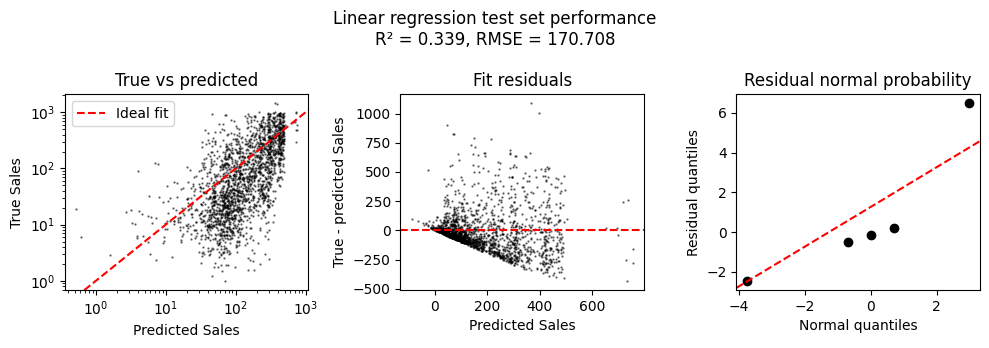

In [11]:
linear_model = funcs.train_evaluate_regression(
    model=LinearRegression(),
    train_df=train_df,
    test_df=test_df,
    label=label,
    plot_title='Linear regression test set performance',
    log_axes=True
)

## 4. Feature importance

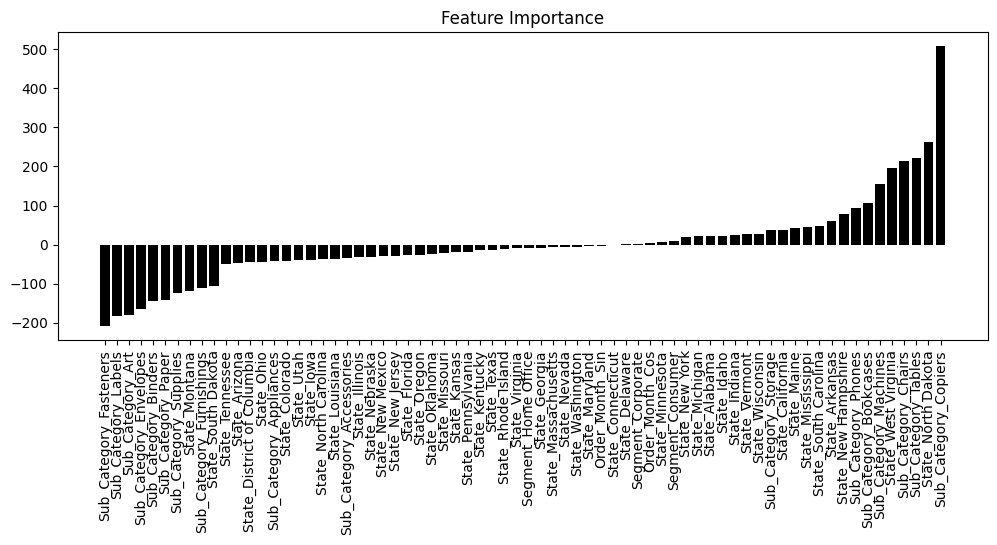

In [12]:
importance = pd.DataFrame({
    'Feature': train_df.drop(label, axis=1).columns,
    'Importance': linear_model.coef_
})

importance = importance[(importance['Importance'] > 0.1) | (importance['Importance'] < -0.1)]
importance.sort_values(by='Importance', inplace=True)

fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.set_title('Feature Importance')
ax.bar(importance['Feature'], importance['Importance'], color='black')
ax.tick_params('x', labelrotation=90)

## 5. Gradient boosting

Training R² = 0.497
Training RMSE = 157.551

Testing R² = 0.303
Testing RMSE = 175.335



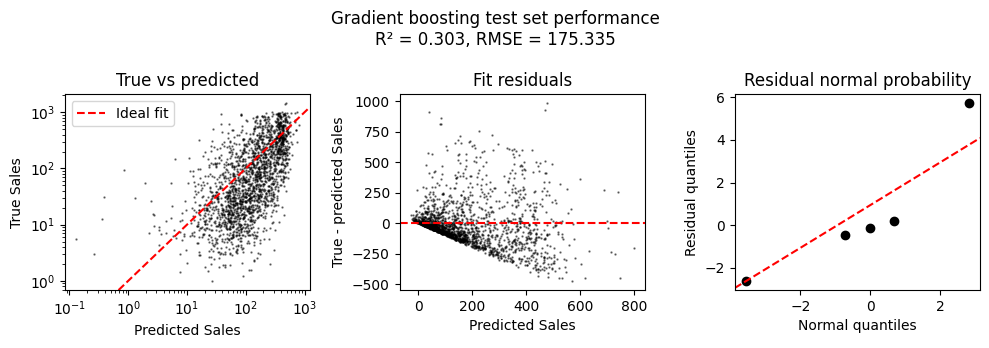

In [13]:
gbt_model = funcs.train_evaluate_regression(
    model=HistGradientBoostingRegressor(),
    train_df=train_df,
    test_df=test_df,
    label=label,
    plot_title='Gradient boosting test set performance',
    log_axes=True
)

## 6. PCA + Gradient boosting

In [14]:
# Samples
N_ITER = 2000

# Cross validation strategy
CV_FOLDS = 10
CV_SPLIT = 0.5

# CPU utilization
N_JOBS = 1

CROSS_VAL = ShuffleSplit(
    n_splits=CV_FOLDS,
    test_size=CV_SPLIT,
    random_state=315
)

In [15]:
# Initialize pipeline components
pca = PCA()
regressor = HistGradientBoostingRegressor()

pipeline = Pipeline(steps=[('PCA', pca), ('regressor', regressor)])

# Define hyperparameter search space for gradient boosting optimization
hyperparameters = {
    'PCA__n_components': list(range(1, len(train_df.columns))),
    'regressor__learning_rate': loguniform(10**-5, 1.0),
    'regressor__max_iter': randint(2, 200),
    'regressor__max_leaf_nodes':randint(2, 1000),
    'regressor__max_depth':randint(1, 20),
    'regressor__min_samples_leaf': randint(1, 20),
    'regressor__l2_regularization': loguniform(10**-5, 1.0),
    'regressor__max_features':uniform(loc=0.1, scale=0.9),
    'regressor__max_bins': randint(10, 255),
    'regressor__interaction_cst': ['pairwise', 'no_interactions'],
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    pipeline,
    hyperparameters,
    return_train_score=True, # Return training scores for analysis
    cv=CROSS_VAL,            # Use stratified shuffle split for cross-validation
    n_jobs=N_JOBS,           # Set CPU core count
    n_iter=N_ITER,           # Number of parameter combinations to try
    random_state=315         # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(train_df.drop(label, axis=1), train_df[label])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

if N_JOBS == -1:
    print(f'Run time ({os.cpu_count()} CPUs):\n')

else:
    print(print(f'Run time ({N_JOBS} CPUs):\n'))

Best hyperparameters:

 PCA__n_components: 60
 regressor__interaction_cst: pairwise
 regressor__l2_regularization: 0.008811403885806035
 regressor__learning_rate: 0.2538869106056704
 regressor__max_bins: 187
 regressor__max_depth: 1
 regressor__max_features: 0.7497269218536171
 regressor__max_iter: 146
 regressor__max_leaf_nodes: 868
 regressor__min_samples_leaf: 4

Run time (1 CPUs):

None


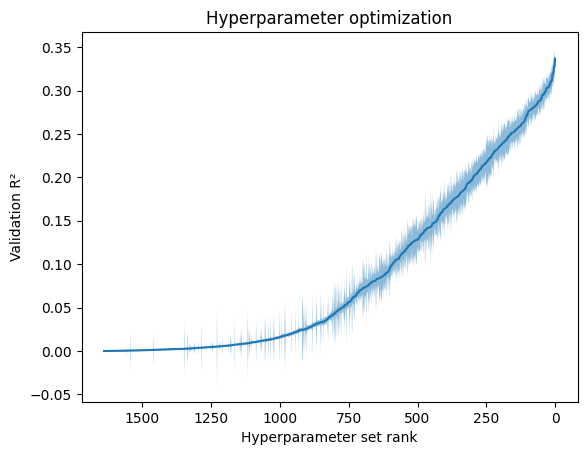

In [16]:
funcs.plot_cross_validation(search_results)

Training R² = 0.403
Training RMSE = 171.613

Testing R² = 0.328
Testing RMSE = 172.182



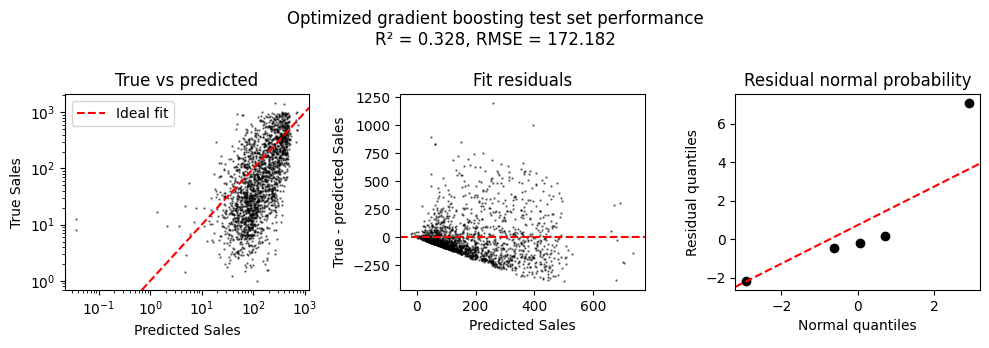

In [17]:
best_gbt_model = funcs.train_evaluate_regression(
    model=best_model,
    train_df=train_df,
    test_df=test_df,
    label=label,
    plot_title='Optimized gradient boosting test set performance',
    log_axes=True
)

## 7. Save

In [18]:
time_transformers = {
    'month_sin': month_sin_transformer,
    'month_cos': month_cos_transformer
}

with open('../models/sales_time_transformers.pkl', 'wb') as output_file:
    pickle.dump(time_transformers, output_file)

with open('../models/sales_onehot_encoder.pkl', 'wb') as output_file:
    pickle.dump(onehot_encoder, output_file)

with open('../models/sales_gbt.pkl', 'wb') as output_file:
    pickle.dump(best_model, output_file)